# Simulations of cross-diffusion system

In [15]:
import numpy as np
from numpy import array

## Initial functions

D_X(V,h) returns the scalar field given by $\frac{V(x+h,y) - V(x,y)}{h}$, a discretisation of the $\frac{\partial}{\partial x}$ operator, and G_X(V,h) returns the scalar field $\frac{V(x+h,y) + V(x,y)}{2}$, a local averaging.

In [16]:
def D_X(V,h):
    direction = -int(np.sign(h))
    return (np.roll(V,direction,axis=1) -V)/h
    

def G_X(V,h):
    direction = -int(np.sign(h))
    return (np.roll(V,direction,axis=1) + V)/2

def G_Y(V,h):
    direction = -int(np.sign(h))
    return (np.roll(V,direction,axis=0) + V)/2

def D_Y(V,h):
    direction = -int(np.sign(h))
    return (np.roll(V,direction,axis=0) -V)/h
    

evolve takes in initial conditions, system parameters and the time increment dt and total number of time steps to be taken and evolves the system for that many time steps.
For each time step the mobility matrix $M$ is computed and this is then fed into the forward_step function which takes one step forward. The forward_step function computes the thermodynamic forces $F$, which is multiplied with $M$ and then the divergence taken to find $\delta \underline{\rho}$.

There is an early termination condition for the evolution of the system. If at any point $\underline{\rho} \not\in \mathcal{D}$ or $\vert \vert \delta \underline{\rho}\vert \vert_{L^2} < minChange$, then the evolve funciton is terminated and the system up to that point is outputted.

The output of the evolve funciton is rho_t_1,rho_t_2,t, wher rho_t_i is an $TimeSteps\times N \times N$ array where $N$ is the space discretisation parameter. 

In [75]:
def evolve(rho_10,rho_20,dt,D_1,D_2,TimeSteps,minChange):
    gamma12 = 2*D_1/(D_1 +D_2)
    gamma21 = 2*D_2/(D_1 +D_2)
    alpha = np.pi/2 - 1
    rho_1 = rho_10
    rho_2 = rho_20
    t = 0
    gamma12 = 2*D_1/(D_1 +D_2)
    gamma21 = 2*D_2/(D_1 +D_2)
    alpha = np.pi/2 - 1
    rho_t_1 = np.zeros((1+TimeSteps,N,N))
    rho_t_2 = np.zeros((1+TimeSteps,N,N))
    i = 0
    rho_t_1[i] = rho_1
    rho_t_2[i] = rho_2
    LastUpdate= 0
    while i< TimeSteps:
        M = np.zeros((2,2,N,N))
        I = np.nonzero((rho_1+rho_2))
        M_00 = M[0,0,:,:]
        M_01 = M[0,1,:,:]
        M_10 =M[1,0,:,:]
        M_11 =M[1,1,:,:]
        M_00[I] += D_1*((1-rho_1-rho_2)[I]/(rho_1+rho_2)[I] )*((rho_1**2)[I] + (rho_1*rho_2 )[I]*(1-alpha*gamma12*(rho_1+rho_2))[I])
        M_01[I] += ((1-rho_1-rho_2)[I] /(rho_1+rho_2)[I] )* ((rho_1*rho_2)[I]-(rho_1*rho_2*(1-alpha*gamma21*(rho_1+rho_2)))[I])
        M_10[I] += ((1-rho_1-rho_2)[I] /(rho_1+rho_2)[I] )*((rho_1*rho_2)[I]-(rho_1*rho_2*(1-alpha*gamma12*(rho_1+rho_2)))[I])
        M_11[I] += D_2*((1-rho_1-rho_2)[I] /(rho_1+rho_2)[I] )*((rho_2**2)[I]+ (rho_1*rho_2 )[I]*(1-alpha*gamma21*(rho_1+rho_2))[I]  )
      #  print(np.amin((np.sqrt(M_00*M_11 - M_01*M_10)**2)))
        rho_1,rho_2,Magnitude_change =  forward_step(rho_1,rho_2,dt,M)
        t +=dt
        i += 1
        if int((100*i/TimeSteps)%5) ==0 and int(100*i/TimeSteps) >0 and int((100*i/TimeSteps))>LastUpdate: 
            print(str(int((100*i/TimeSteps))) + "% completed. Current value of dp/dt = "+ str(Magnitude_change))
            LastUpdate = int((100*i/TimeSteps))

        rho_t_1[i] = rho_1
        rho_t_2[i] = rho_2
        if len(np.argwhere(rho_1 <0 )) >0 or  len(np.argwhere(rho_2 <0 )) >0 or  len(np.argwhere(rho_1 +rho_2>1 )) >0 or Magnitude_change < minChange:
            print('ended early at  i='+str(i))
            return rho_t_1[:i+1,:,:],rho_t_2[:i+1,:,:],np.linspace(0,dt*(i+1),i+1)
            break
        #print('Got to i = ' +str(i)+', successfully!')
    
    return rho_t_1,rho_t_2,np.linspace(0,dt*(i+1),i+1)

def forward_step(rho_1,rho_2,dt,M):
    rho= rho_1 +rho_2
    rhos_new = array([rho_1,rho_2])
    
    F_1_plus_X = G_X(DV_1(X)[0],h)   # Initially set to the forces due to potential
    I1= np.nonzero(G_X(rho_1,h))  # Find indices where no division by zero
    F_1_plus_X[I1] += D_X(rho_1,h)[I1]/G_X(rho_1,h)[I1] # Adding the forcing values at these indices due to species 1 density
    I2 = np.nonzero(1-G_X(rho,h))  # Find indices where no division by zero
    F_1_plus_X[I2] += D_X(rho,h)[I2]/(1-G_X(rho,h))[I2]  # Adding the forcing values at these indices due to total species density
    
    F_1_plus_Y = G_Y(DV_1(X)[1],h)
    I1= np.nonzero(G_Y(rho_1,h))
    F_1_plus_Y[I1] += D_Y(rho_1,h)[I1]/G_Y(rho_1,h)[I1]
    I3 = np.nonzero(1-G_Y(rho,h))
    F_1_plus_Y[I3] += D_Y(rho,h)[I3]/(1-G_Y(rho,h))[I3]
    
    F_1_minus_X = G_X(DV_1(X)[0],-h)
    I1= np.nonzero(G_X(rho_1,-h))
    F_1_minus_X[I1] += D_X(rho_1,-h)[I1]/G_X(rho_1,-h)[I1]
    F_1_minus_X[I2] += D_X(rho,-h)[I2]/(1-G_X(rho,-h))[I2]
    
    F_1_minus_Y = G_Y(DV_1(X)[1],-h)
    I1= np.nonzero(G_Y(rho_1,-h))
    F_1_minus_Y[I1] += D_Y(rho_1,-h)[I1]/G_Y(rho_1,-h)[I1]
    F_1_minus_Y[I3] += D_Y(rho,-h)[I3]/(1-G_Y(rho,-h))[I3]
    
    F_2_plus_X = G_X(DV_2(X)[0],h)
    I1= np.nonzero(G_X(rho_2,h))
    F_2_plus_X[I1] += D_X(rho_2,h)[I1]/G_X(rho_2,h)[I1]
    F_2_plus_X[I2] += D_X(rho,h)[I2]/(1-G_X(rho,h))[I2]
    
    F_2_plus_Y = G_Y(DV_2(X)[1],h)
    I1= np.nonzero(G_Y(rho_2,h))
    F_2_plus_Y[I1] += D_Y(rho_2,h)[I1]/G_Y(rho_2,h)[I1]
    F_2_plus_Y[I3] += D_Y(rho,h)[I3]/(1-G_Y(rho,h))[I3]
    
    F_2_minus_X = G_X(DV_2(X)[0],-h)
    I1= np.nonzero(G_X(rho_2,-h))
    F_2_minus_X[I1] += D_X(rho_2,-h)[I1]/G_X(rho_2,-h)[I1]
    F_2_minus_X[I2] += D_X(rho,-h)[I2]/(1-G_X(rho,-h))[I2]
    
    F_2_minus_Y = G_Y(DV_2(X)[1],-h)
    I1= np.nonzero(G_Y(rho_2,-h))
    F_2_minus_Y[I1] += D_Y(rho_2,-h)[I1]/G_Y(rho_2,-h)[I1]
    F_2_minus_Y[I3] += D_Y(rho,-h)[I3]/(1-G_Y(rho,-h))[I3]
    
    J_plus_X = np.einsum( 'ijkl,jkl ->ikl'  ,M,array([F_1_plus_X, F_2_plus_X] ))
    J_minus_X = np.einsum( 'ijkl,jkl ->ikl'  ,M,array([F_1_minus_X, F_2_minus_X]))
    J_plus_Y = np.einsum( 'ijkl,jkl ->ikl'  ,M,array([F_1_plus_Y, F_2_plus_Y] ))
    J_minus_Y = np.einsum( 'ijkl,jkl ->ikl'  ,M,array([F_1_minus_Y, F_2_minus_Y]))
    rhos_new += (dt/h**1)*(J_plus_X - J_minus_X + J_plus_Y - J_minus_Y)
    Magnitude_change = np.sqrt(np.sum((J_plus_X - J_minus_X + J_plus_Y - J_minus_Y)**2))*h**2
    #print(np.sqrt(np.amax( (J_plus_X - J_minus_X + J_plus_Y - J_minus_Y)**2)))
    return rhos_new[0],rhos_new[1],Magnitude_change

## Numerical experiments
---


Create the lattice of the torus 

In [18]:
def makeSystem(N,D_1,D_2, dim = 2):
    h = 1/N
    Omega = np.meshgrid(np.linspace(0,1-h,N),np.linspace(0,1-h,N))
    return Omega, h,N

Omega, h,N = makeSystem(100,1,2, dim = 2)
D_1 = 1
D_2 = 1
X,Y =Omega

Set initial conditions of the densities and the energy potentials. 

In [119]:
eps = 0.01
rho_10 = 0*X +eps
rho_10[np.argwhere(X[0,:] <0.75)] = 0.25
rho_10[np.argwhere(X[0,:] <.25)] = 0
rho_20 = 0*X +eps
#rho_20[np.argwhere(X[0,:] <0.75)] = 0.35
#rho_20[np.argwhere(X[0,:] <.25)] = 0

V_1 = lambda x : np.sin(2*np.pi*x)
V_2 = lambda x :  -np.sin(2*np.pi*x) # 0*np.cos(2*np.pi*x)
DV_1 = lambda x: array( [2*np.pi*np.cos( 2*np.pi*x), 0*x])
DV_2 = lambda x: -DV_1(x) #0*array( [-2*np.pi*np.sin( 2*np.pi*x), 0*x ])

Evolve the system

In [120]:
rho_t_1,rho_t_2,t = evolve(rho_10,rho_20,.1*h**2,D_1,D_2,3000,0.005)

ended early at  i=60


## Visualisation
---
Here an animation is created showing the evolution of the individual densities along side the energy potentials $V$.

In [107]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.animation import FuncAnimation

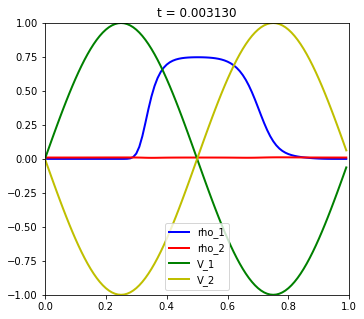

In [112]:
fig = plt.figure(figsize=(12,5))
ax = plt.subplot(1,2,1)   
txt_title = ax.set_title('')
ax.set_xlim(( 0, 1))            
ax.set_ylim((-1, 1))
line1, = ax.plot([], [], 'b', lw=2, label = 'rho_1')  
line2, = ax.plot([], [], 'r', lw=2, label = 'rho_2')  
line3, = ax.plot([], [], 'g', lw=2, label = 'V_1')  
line4, = ax.plot([], [], 'y', lw=2, label = 'V_2')  
ax.legend()
def animate(i):
     # grab a random integer to be the next y-value in the animation
    x = np.linspace(0,1-h,N)
    y1 = rho_t_1[i,:,0] #+  rho_t_2[i,:,0]
    y2 = rho_t_2[i,:,0]
    line1.set_data(x, y1)
    line2.set_data(x, y2)
    line3.set_data(x, V_1(x))
    line4.set_data(x,  V_2(x))
    txt_title.set_text('t = {0:4f}'.format(t[i]))
    return line1,line2,line3,line4,
ani = FuncAnimation(fig, animate, frames=rho_t_1.shape[0], interval=20,  blit=True)

ani.save('System Evolution, effect of potential.mp4',
		writer = 'ffmpeg', fps = 30)

Final plot of densities

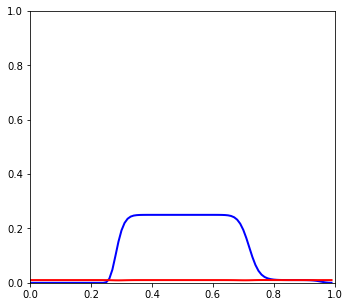

In [121]:
fig = plt.figure(figsize=(12,5))
ax = plt.subplot(1,2,1)   
txt_title = ax.set_title('')
ax.set_xlim(( 0, 1))            
ax.set_ylim((0, 1))
line1, = ax.plot([], [], 'b', lw=2)  
line2, = ax.plot([], [], 'r', lw=2)  

x = np.linspace(0,1-h,N)
y1 = rho_t_1[-1,:,0]
line1.set_data(x, y1)
y2 = rho_t_2[-1,:,0]
line2.set_data(x, y2)

Plotting evolution of Entropy functional

In [122]:
def E(rho_1,rho_2):
    I1 = np.nonzero(rho_1)
    I2 = np.nonzero(rho_2)
    rho = rho_1 +rho_2
    I3 = np.nonzero(rho)
    E_0 = h**2*(np.sum(rho_1[I1]*np.log(rho_1[I1])) +np.sum(rho_2[I2]*np.log(rho_2[I2]))  +np.sum((1- rho[I3])*np.log(1-rho[I3])))
    E_V = h**2*np.sum(rho_1*V_1(X) + rho_2*V_2(X))
    return E_0 +E_V
x = np.linspace(0,t[-1],rho_t_1.shape[0])
y =0*x
for j in range(0,len(x)):
    y[j] = E(rho_t_1[j],rho_t_2[j])

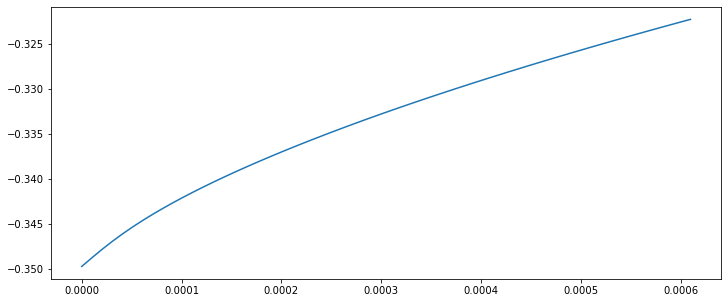

In [123]:
fig = plt.figure(figsize=(12,5))

plt.plot(x,y)

In current code it seems that the mass of the species is decreasing over time. This is a plot of the total mass of each species.

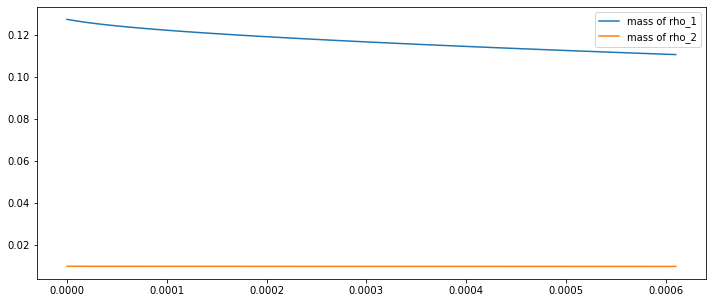

In [124]:
x = np.linspace(0,t[-1],rho_t_1.shape[0])
mass_1 =0*x
mass_2 =0*x
for j in range(0,len(x)):
    mass_1[j] = np.sum(rho_t_1[j,:,:])*h**2
    mass_2[j] = np.sum(rho_t_2[j,:,:])*h**2
    
fig = plt.figure(figsize=(12,5))

plt.plot(x,mass_1, label = 'mass of rho_1')
plt.plot(x,mass_2, label = 'mass of rho_2')

plt.legend()
plt.show()